In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 128
n_embeddings= 768
output_dim = 3

lr = 2e-4

epochs = 5

print_step = 50

In [18]:
DEVICE

device(type='cuda')

###    Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

Files already downloaded and verified
Files already downloaded and verified


### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        return y

In [5]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity
    
    

In [8]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [9]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [10]:
%%time
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
              "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1   step: 1   recon_loss: 0.3475685119628906   perplexity:  37.66936492919922 
		commit_loss:  0.007679786067456007   codebook loss:  0.030719144269824028   total_loss:  0.3859674334526062
epoch: 1   step: 51   recon_loss: 0.04639124125242233   perplexity:  30.016141891479492 
		commit_loss:  0.032105702906847   codebook loss:  0.128422811627388   total_loss:  0.20691975951194763
epoch: 1   step: 101   recon_loss: 0.039908405393362045   perplexity:  49.54026412963867 
		commit_loss:  0.041401349008083344   codebook loss:  0.16560539603233337   total_loss:  0.24691514670848846
epoch: 1   step: 151   recon_loss: 0.03378502279520035   perplexity:  69.55818939208984 
		commit_loss:  0.036832038313150406   codebook loss:  0.14732815325260162   total_loss:  0.21794521808624268
epoch: 1   step: 201   recon_loss: 0.0337766595184803   perplexity:  79.94493865966797 
		commit_loss:  0.04286780580878258   codebook loss:  0.1714712232351303   total_loss:  0.24811568

In [11]:
38*60/10

228.0

### Step 5. Evaluate the model

In [12]:
import matplotlib.pyplot as plt

In [13]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [14]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        #break

  6%|██████▍                                                                                               | 5/79 [00:04<00:46,  1.60it/s]

perplexity:  514.5888061523438 commit_loss:  0.031619757413864136   codebook loss:  0.12647902965545654
perplexity:  518.2875366210938 commit_loss:  0.03438781201839447   codebook loss:  0.13755124807357788
perplexity:  513.3125 commit_loss:  0.031037721782922745   codebook loss:  0.12415088713169098
perplexity:  520.1275634765625 commit_loss:  0.031070683151483536   codebook loss:  0.12428273260593414
perplexity:  518.5127563476562 commit_loss:  0.03155200183391571   codebook loss:  0.12620800733566284
perplexity:  510.2683410644531 commit_loss:  0.03131186589598656   codebook loss:  0.12524746358394623
perplexity:  505.1235046386719 commit_loss:  0.030717894434928894   codebook loss:  0.12287157773971558


 16%|████████████████▌                                                                                    | 13/79 [00:04<00:11,  5.58it/s]

perplexity:  523.3989868164062 commit_loss:  0.03132190182805061   codebook loss:  0.12528760731220245
perplexity:  517.810302734375 commit_loss:  0.030390150845050812   codebook loss:  0.12156060338020325
perplexity:  523.3253173828125 commit_loss:  0.03186120092868805   codebook loss:  0.1274448037147522
perplexity:  515.2583618164062 commit_loss:  0.03245377913117409   codebook loss:  0.12981511652469635
perplexity:  520.98388671875 commit_loss:  0.03252917155623436   codebook loss:  0.13011668622493744
perplexity:  510.71746826171875 commit_loss:  0.03220050036907196   codebook loss:  0.12880200147628784
perplexity:  516.1710205078125 commit_loss:  0.031440868973731995   codebook loss:  0.12576347589492798
perplexity:  515.5491333007812 commit_loss:  0.032865654677152634   codebook loss:  0.13146261870861053


 27%|██████████████████████████▊                                                                          | 21/79 [00:04<00:05, 11.30it/s]

perplexity:  528.3596801757812 commit_loss:  0.032865263521671295   codebook loss:  0.13146105408668518
perplexity:  507.7571716308594 commit_loss:  0.03007347881793976   codebook loss:  0.12029391527175903
perplexity:  519.5083618164062 commit_loss:  0.03074204921722412   codebook loss:  0.12296819686889648
perplexity:  508.44866943359375 commit_loss:  0.03025205060839653   codebook loss:  0.12100820243358612
perplexity:  520.4959716796875 commit_loss:  0.03202445060014725   codebook loss:  0.128097802400589
perplexity:  476.4604187011719 commit_loss:  0.02912689745426178   codebook loss:  0.11650758981704712
perplexity:  547.9827880859375 commit_loss:  0.035883981734514236   codebook loss:  0.14353592693805695
perplexity:  519.33349609375 commit_loss:  0.03327701985836029   codebook loss:  0.13310807943344116


 37%|█████████████████████████████████████                                                                | 29/79 [00:04<00:02, 18.51it/s]

perplexity:  507.7257080078125 commit_loss:  0.03078005090355873   codebook loss:  0.12312020361423492
perplexity:  502.5530700683594 commit_loss:  0.03270212188363075   codebook loss:  0.130808487534523
perplexity:  542.9732666015625 commit_loss:  0.0345909520983696   codebook loss:  0.1383638083934784
perplexity:  503.6292419433594 commit_loss:  0.03153051808476448   codebook loss:  0.12612207233905792
perplexity:  506.3459167480469 commit_loss:  0.032503094524145126   codebook loss:  0.1300123780965805
perplexity:  516.6959838867188 commit_loss:  0.03185809403657913   codebook loss:  0.12743237614631653
perplexity:  533.1200561523438 commit_loss:  0.0346447192132473   codebook loss:  0.1385788768529892
perplexity:  498.6533508300781 commit_loss:  0.03204471617937088   codebook loss:  0.12817886471748352
perplexity:  501.72821044921875 commit_loss:  0.030688254162669182   codebook loss:  0.12275301665067673


 48%|████████████████████████████████████████████████▌                                                    | 38/79 [00:05<00:01, 26.22it/s]

perplexity:  513.5301513671875 commit_loss:  0.03249159827828407   codebook loss:  0.1299663931131363
perplexity:  527.5936279296875 commit_loss:  0.03111564740538597   codebook loss:  0.12446258962154388
perplexity:  537.294677734375 commit_loss:  0.033739037811756134   codebook loss:  0.13495615124702454
perplexity:  521.4854736328125 commit_loss:  0.03131183609366417   codebook loss:  0.12524734437465668
perplexity:  502.5401611328125 commit_loss:  0.03066570684313774   codebook loss:  0.12266282737255096
perplexity:  542.1559448242188 commit_loss:  0.03555639088153839   codebook loss:  0.14222556352615356
perplexity:  535.6544189453125 commit_loss:  0.0337759405374527   codebook loss:  0.1351037621498108
perplexity:  525.3252563476562 commit_loss:  0.03171525523066521   codebook loss:  0.12686102092266083
perplexity:  502.5698547363281 commit_loss:  0.031210321933031082   codebook loss:  0.12484128773212433


 58%|██████████████████████████████████████████████████████████▊                                          | 46/79 [00:05<00:01, 30.83it/s]

perplexity:  533.1864013671875 commit_loss:  0.031626202166080475   codebook loss:  0.1265048086643219
perplexity:  535.1836547851562 commit_loss:  0.034787409007549286   codebook loss:  0.13914963603019714
perplexity:  507.515625 commit_loss:  0.03127896785736084   codebook loss:  0.12511587142944336
perplexity:  530.1843872070312 commit_loss:  0.03175363317131996   codebook loss:  0.12701453268527985
perplexity:  512.6254272460938 commit_loss:  0.0309805516153574   codebook loss:  0.1239222064614296
perplexity:  529.4906005859375 commit_loss:  0.032838355749845505   codebook loss:  0.13135342299938202
perplexity:  522.2347412109375 commit_loss:  0.031242147088050842   codebook loss:  0.12496858835220337
perplexity:  521.037109375 commit_loss:  0.03169615566730499   codebook loss:  0.12678462266921997


 68%|█████████████████████████████████████████████████████████████████████                                | 54/79 [00:05<00:00, 33.54it/s]

perplexity:  507.35687255859375 commit_loss:  0.030972696840763092   codebook loss:  0.12389078736305237
perplexity:  530.2885131835938 commit_loss:  0.03062250092625618   codebook loss:  0.12249000370502472
perplexity:  523.6992797851562 commit_loss:  0.030979517847299576   codebook loss:  0.1239180713891983
perplexity:  495.66729736328125 commit_loss:  0.03149045631289482   codebook loss:  0.12596182525157928
perplexity:  530.5108642578125 commit_loss:  0.03343794122338295   codebook loss:  0.1337517648935318
perplexity:  506.729736328125 commit_loss:  0.03170579671859741   codebook loss:  0.12682318687438965
perplexity:  513.1832885742188 commit_loss:  0.03138052299618721   codebook loss:  0.12552209198474884
perplexity:  518.5258178710938 commit_loss:  0.030017083510756493   codebook loss:  0.12006833404302597


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 63/79 [00:05<00:00, 36.25it/s]

perplexity:  508.8684997558594 commit_loss:  0.03225836902856827   codebook loss:  0.12903347611427307
perplexity:  526.3304443359375 commit_loss:  0.03215663880109787   codebook loss:  0.12862655520439148
perplexity:  518.8013305664062 commit_loss:  0.03159524127840996   codebook loss:  0.12638096511363983
perplexity:  513.6101684570312 commit_loss:  0.03214767202734947   codebook loss:  0.1285906881093979
perplexity:  517.8759765625 commit_loss:  0.03233723342418671   codebook loss:  0.12934893369674683
perplexity:  526.6949462890625 commit_loss:  0.03183421492576599   codebook loss:  0.12733685970306396
perplexity:  519.5693359375 commit_loss:  0.03237180784344673   codebook loss:  0.12948723137378693
perplexity:  536.20947265625 commit_loss:  0.03225136920809746   codebook loss:  0.12900547683238983


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 71/79 [00:05<00:00, 33.06it/s]

perplexity:  504.5279541015625 commit_loss:  0.02967042662203312   codebook loss:  0.11868170648813248
perplexity:  530.522216796875 commit_loss:  0.03248428553342819   codebook loss:  0.12993714213371277
perplexity:  531.4743041992188 commit_loss:  0.03278915211558342   codebook loss:  0.13115660846233368
perplexity:  521.1312255859375 commit_loss:  0.031243300065398216   codebook loss:  0.12497320026159286
perplexity:  516.31201171875 commit_loss:  0.030435819178819656   codebook loss:  0.12174327671527863
perplexity:  509.3882751464844 commit_loss:  0.0314699150621891   codebook loss:  0.1258796602487564


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 75/79 [00:06<00:00, 31.76it/s]

perplexity:  518.21240234375 commit_loss:  0.030069340020418167   codebook loss:  0.12027736008167267
perplexity:  535.865966796875 commit_loss:  0.032709751278162   codebook loss:  0.130839005112648
perplexity:  537.8160400390625 commit_loss:  0.03366279974579811   codebook loss:  0.13465119898319244
perplexity:  522.8728637695312 commit_loss:  0.03156009688973427   codebook loss:  0.12624038755893707
perplexity:  517.1177368164062 commit_loss:  0.031181856989860535   codebook loss:  0.12472742795944214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 28.06it/s]

perplexity:  505.4507141113281 commit_loss:  0.03162388876080513   codebook loss:  0.12649555504322052
perplexity:  519.7994995117188 commit_loss:  0.03299742564558983   codebook loss:  0.13198970258235931
perplexity:  362.3506774902344 commit_loss:  0.040443871170282364   codebook loss:  0.16177548468112946


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.79it/s]


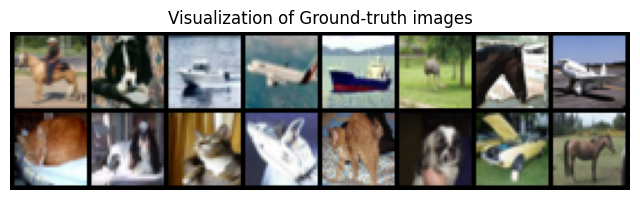

In [15]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

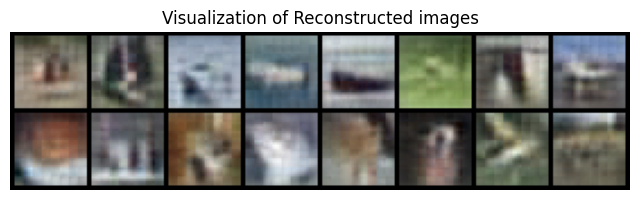

In [16]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

In [17]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))

NameError: name 'draw_random_sample_image' is not defined

In [22]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        #break

  6%|██████▍                                                                                               | 5/79 [00:02<00:30,  2.44it/s]

perplexity:  623.2454223632812 commit_loss:  0.028057001531124115   codebook loss:  0.11222800612449646
perplexity:  630.697265625 commit_loss:  0.029688065871596336   codebook loss:  0.11875226348638535
perplexity:  615.9873046875 commit_loss:  0.027541518211364746   codebook loss:  0.11016607284545898
perplexity:  622.6397094726562 commit_loss:  0.027422994375228882   codebook loss:  0.10969197750091553
perplexity:  630.830810546875 commit_loss:  0.02809537574648857   codebook loss:  0.11238150298595428
perplexity:  616.3475341796875 commit_loss:  0.027412494644522667   codebook loss:  0.10964997857809067
perplexity:  619.279052734375 commit_loss:  0.02734798938035965   codebook loss:  0.1093919575214386
perplexity:  621.2023315429688 commit_loss:  0.028165310621261597   codebook loss:  0.11266124248504639
perplexity:  631.615478515625 commit_loss:  0.02759293094277382   codebook loss:  0.11037172377109528


 19%|███████████████████▏                                                                                 | 15/79 [00:02<00:06,  9.39it/s]

perplexity:  631.0516357421875 commit_loss:  0.02823561243712902   codebook loss:  0.11294244974851608
perplexity:  614.6265258789062 commit_loss:  0.02833598665893078   codebook loss:  0.11334394663572311
perplexity:  633.88232421875 commit_loss:  0.028748029842972755   codebook loss:  0.11499211937189102
perplexity:  618.3905029296875 commit_loss:  0.028110232204198837   codebook loss:  0.11244092881679535
perplexity:  615.0269775390625 commit_loss:  0.028093228116631508   codebook loss:  0.11237291246652603
perplexity:  625.0936279296875 commit_loss:  0.028596552088856697   codebook loss:  0.11438620835542679
perplexity:  620.0103149414062 commit_loss:  0.028645595535635948   codebook loss:  0.11458238214254379
perplexity:  622.7867431640625 commit_loss:  0.02659822441637516   codebook loss:  0.10639289766550064
perplexity:  619.2752075195312 commit_loss:  0.027456171810626984   codebook loss:  0.10982468724250793


 30%|██████████████████████████████▋                                                                      | 24/79 [00:03<00:03, 17.43it/s]

perplexity:  619.9098510742188 commit_loss:  0.02666943147778511   codebook loss:  0.10667772591114044
perplexity:  628.043701171875 commit_loss:  0.02817290648818016   codebook loss:  0.11269162595272064
perplexity:  600.2501831054688 commit_loss:  0.02591082453727722   codebook loss:  0.10364329814910889
perplexity:  639.639404296875 commit_loss:  0.03070000186562538   codebook loss:  0.12280000746250153
perplexity:  625.6802978515625 commit_loss:  0.02913689613342285   codebook loss:  0.1165475845336914
perplexity:  622.599609375 commit_loss:  0.027614016085863113   codebook loss:  0.11045606434345245
perplexity:  612.3777465820312 commit_loss:  0.02922843024134636   codebook loss:  0.11691372096538544
perplexity:  630.50390625 commit_loss:  0.030174870043992996   codebook loss:  0.12069948017597198
perplexity:  612.6558227539062 commit_loss:  0.02737555280327797   codebook loss:  0.10950221121311188


 43%|███████████████████████████████████████████▍                                                         | 34/79 [00:03<00:01, 26.39it/s]

perplexity:  621.7161865234375 commit_loss:  0.028356287628412247   codebook loss:  0.11342515051364899
perplexity:  620.0162353515625 commit_loss:  0.027892064303159714   codebook loss:  0.11156825721263885
perplexity:  625.8882446289062 commit_loss:  0.03023689240217209   codebook loss:  0.12094756960868835
perplexity:  611.4403076171875 commit_loss:  0.028095021843910217   codebook loss:  0.11238008737564087
perplexity:  615.8486938476562 commit_loss:  0.027793724089860916   codebook loss:  0.11117489635944366
perplexity:  622.4918823242188 commit_loss:  0.027934249490499496   codebook loss:  0.11173699796199799
perplexity:  621.030517578125 commit_loss:  0.027613813057541847   codebook loss:  0.11045525223016739
perplexity:  640.1172485351562 commit_loss:  0.02976391464471817   codebook loss:  0.11905565857887268


 56%|████████████████████████████████████████████████████████▎                                            | 44/79 [00:03<00:01, 33.39it/s]

perplexity:  624.1012573242188 commit_loss:  0.027916479855775833   codebook loss:  0.11166591942310333
perplexity:  614.7431640625 commit_loss:  0.02783859334886074   codebook loss:  0.11135437339544296
perplexity:  638.7195434570312 commit_loss:  0.031250953674316406   codebook loss:  0.12500381469726562
perplexity:  638.6644287109375 commit_loss:  0.02957206591963768   codebook loss:  0.11828826367855072
perplexity:  623.4154052734375 commit_loss:  0.027736037969589233   codebook loss:  0.11094415187835693
perplexity:  626.1652221679688 commit_loss:  0.0277887973934412   codebook loss:  0.1111551895737648
perplexity:  632.3866577148438 commit_loss:  0.02771596796810627   codebook loss:  0.11086387187242508
perplexity:  627.687744140625 commit_loss:  0.030373062938451767   codebook loss:  0.12149225175380707
perplexity:  622.5438232421875 commit_loss:  0.02737336978316307   codebook loss:  0.10949347913265228
perplexity:  623.3577270507812 commit_loss:  0.027935175225138664   codeboo

 68%|█████████████████████████████████████████████████████████████████████                                | 54/79 [00:03<00:00, 37.92it/s]

perplexity:  621.366455078125 commit_loss:  0.02770092710852623   codebook loss:  0.11080370843410492
perplexity:  635.4584350585938 commit_loss:  0.02874787151813507   codebook loss:  0.11499148607254028
perplexity:  620.4669799804688 commit_loss:  0.026976078748703003   codebook loss:  0.10790431499481201
perplexity:  624.0188598632812 commit_loss:  0.028015829622745514   codebook loss:  0.11206331849098206
perplexity:  623.6806030273438 commit_loss:  0.027708910405635834   codebook loss:  0.11083564162254333
perplexity:  624.568115234375 commit_loss:  0.02661852352321148   codebook loss:  0.10647409409284592
perplexity:  628.7562866210938 commit_loss:  0.0273904912173748   codebook loss:  0.1095619648694992
perplexity:  611.27880859375 commit_loss:  0.028169285506010056   codebook loss:  0.11267714202404022
perplexity:  629.4342041015625 commit_loss:  0.029293755069375038   codebook loss:  0.11717502027750015


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 64/79 [00:04<00:00, 40.27it/s]

perplexity:  612.2396240234375 commit_loss:  0.027903703972697258   codebook loss:  0.11161481589078903
perplexity:  617.810791015625 commit_loss:  0.0271826833486557   codebook loss:  0.1087307333946228
perplexity:  624.7009887695312 commit_loss:  0.027073832228779793   codebook loss:  0.10829532891511917
perplexity:  615.8386840820312 commit_loss:  0.028172247111797333   codebook loss:  0.11268898844718933
perplexity:  626.5472412109375 commit_loss:  0.028731273487210274   codebook loss:  0.1149250939488411
perplexity:  623.7963256835938 commit_loss:  0.02816639095544815   codebook loss:  0.1126655638217926
perplexity:  624.9661254882812 commit_loss:  0.02833603508770466   codebook loss:  0.11334414035081863
perplexity:  619.6104736328125 commit_loss:  0.02850291132926941   codebook loss:  0.11401164531707764
perplexity:  634.2608642578125 commit_loss:  0.028345724567770958   codebook loss:  0.11338289827108383
perplexity:  623.627685546875 commit_loss:  0.028656894341111183   codebo

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 69/79 [00:04<00:00, 40.89it/s]

perplexity:  632.6026000976562 commit_loss:  0.02835780754685402   codebook loss:  0.11343123018741608
perplexity:  617.8794555664062 commit_loss:  0.026143915951251984   codebook loss:  0.10457566380500793
perplexity:  631.7079467773438 commit_loss:  0.028767157346010208   codebook loss:  0.11506862938404083
perplexity:  628.319580078125 commit_loss:  0.029127372428774834   codebook loss:  0.11650948971509933
perplexity:  615.0929565429688 commit_loss:  0.027482783421874046   codebook loss:  0.10993113368749619
perplexity:  624.3599243164062 commit_loss:  0.0271112322807312   codebook loss:  0.1084449291229248
perplexity:  626.6249389648438 commit_loss:  0.027559403330087662   codebook loss:  0.11023761332035065
perplexity:  621.715576171875 commit_loss:  0.026347162202000618   codebook loss:  0.10538864880800247
perplexity:  633.265380859375 commit_loss:  0.02873862162232399   codebook loss:  0.11495448648929596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 40.77it/s]

perplexity:  639.791015625 commit_loss:  0.02971465140581131   codebook loss:  0.11885860562324524
perplexity:  631.2144165039062 commit_loss:  0.027938678860664368   codebook loss:  0.11175471544265747
perplexity:  621.1022338867188 commit_loss:  0.027645204216241837   codebook loss:  0.11058081686496735
perplexity:  611.9267578125 commit_loss:  0.027644526213407516   codebook loss:  0.11057810485363007
perplexity:  629.8911743164062 commit_loss:  0.028307415544986725   codebook loss:  0.1132296621799469
perplexity:  432.8076477050781 commit_loss:  0.03407909348607063   codebook loss:  0.13631637394428253


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.52it/s]


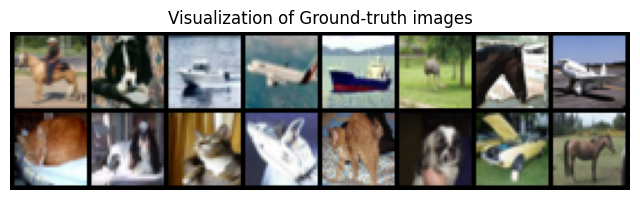

In [23]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

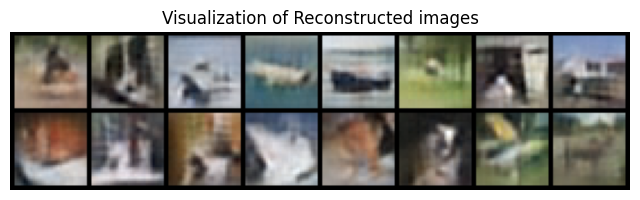

In [24]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [25]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

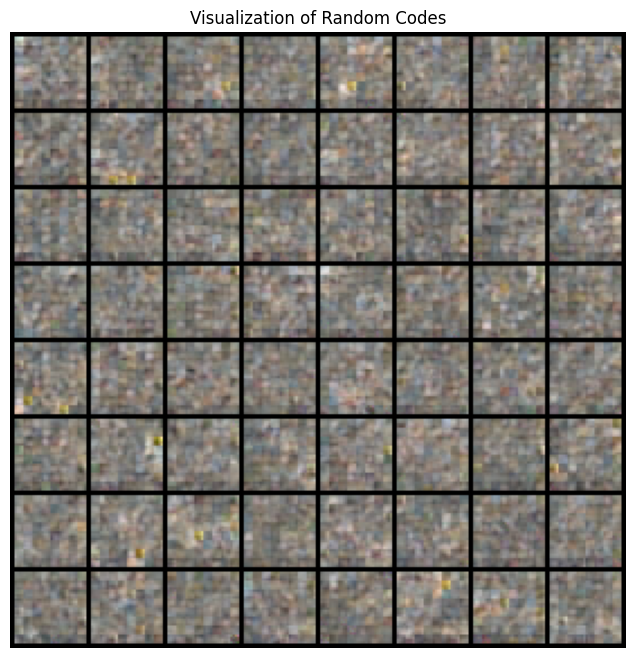

In [26]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))